In [4]:
!pip install joblib
!pip install numpy 
!pip install pandas
!pip install torch 
!pip install xgboost
!pip install matplotlib
!pip install tensorflow 
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl (11.4 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-

/Users/amruthabhat/.pyenv/versions/3.12.3/lib/python3.12/pickle.py:1710: UserWarning: [22:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

📊 Model Evaluation Results:
✅ RMSE: 62.8398
✅ R² Score: 0.9521
✅ MAE: 37.1807
✅ MAPE: 16.56%


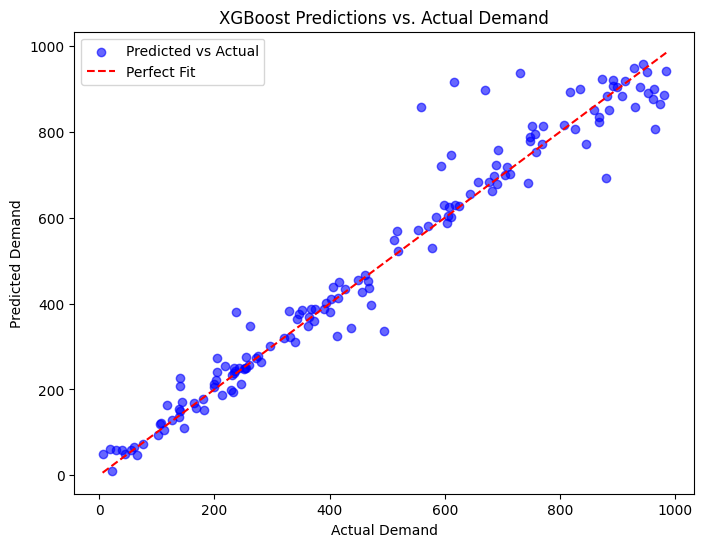

In [6]:
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xgboost as xgb
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 🔹 Load the test dataset
data = pd.read_csv("/Users/amruthabhat/Documents/demand_forecasting/src/engineered_data.csv")

# 🔹 Define feature columns and target
TARGET_COLUMN = "demand_forecast"
features = data.columns.tolist()
features.remove("product_id")
features.remove("product_name")
features.remove("category")
features.remove("supplier_id")
features.remove(TARGET_COLUMN)

X = data[features]
y = data[TARGET_COLUMN]

# 🔹 Split into training, validation, and test sets (same as train.py)
_, X_temp, _, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 🔹 Load the trained BiLSTM model


bi_lstm_model = load_model("/Users/amruthabhat/Documents/demand_forecasting/src/bi_lstm_model.h5", compile=False)
bi_lstm_model.compile(loss=MeanSquaredError())  # Explicitly set the loss function


# 🔹 Define NARX Model Class (to match training structure)
class NARXModel(nn.Module):
    def __init__(self, input_size):
        super(NARXModel, self).__init__()
        self.hidden_layer = nn.Linear(input_size + 1, 32)  # +1 for previous output
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x, prev_output):
        x = torch.cat((x, prev_output), dim=1)
        x = torch.relu(self.hidden_layer(x))
        return self.output_layer(x)

# 🔹 Load NARX Model Properly
input_size = X_test.shape[1]  # Match feature size
narx_model = NARXModel(input_size)
narx_model.load_state_dict(torch.load("/Users/amruthabhat/Documents/demand_forecasting/src/narx_model.pth"))
narx_model.eval()  # Set to evaluation mode

# 🔹 Load XGBoost Model
xgb_reg = joblib.load("/Users/amruthabhat/Documents/demand_forecasting/src/xgboost_model.pkl")

# 🔹 Reshape test data for BiLSTM (3D: [samples, timesteps, features])
def reshape_for_lstm(X):
    return np.expand_dims(X.values, axis=1)

X_test_lstm = reshape_for_lstm(X_test)

# 🔹 Generate BiLSTM features
lstm_features_test = bi_lstm_model.predict(X_test_lstm).flatten()

# 🔹 Generate NARX features
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
prev_output_test = torch.zeros((X_test.shape[0], 1), dtype=torch.float32)
y_pred_narx_test = narx_model(X_test_torch, prev_output_test).detach().numpy().flatten()

# 🔹 Ensure Test Data Has the Same Shape (Convert NumPy Arrays to Pandas DataFrame)
lstm_features_df = pd.DataFrame(lstm_features_test, columns=["lstm_feature"])
narx_features_df = pd.DataFrame(y_pred_narx_test, columns=["narx_feature"])

X_test_combined = pd.concat([X_test.reset_index(drop=True), lstm_features_df, narx_features_df], axis=1)

# 🔹 Predict using XGBoost
y_pred = xgb_reg.predict(X_test_combined)

# 🔹 Compute Error Metrics (Handle Division by Zero in MAPE)
nonzero_y_test = y_test[y_test != 0]
nonzero_y_pred = y_pred[y_test != 0]  # Ensure corresponding values are selected

rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((nonzero_y_test - nonzero_y_pred) / nonzero_y_test)) * 100 if len(nonzero_y_test) > 0 else 0

# 🔹 Print Results
print("\n📊 Model Evaluation Results:")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ MAPE: {mape:.2f}%")

# 🔹 Plot Predictions vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("XGBoost Predictions vs. Actual Demand")
plt.legend()
plt.show()


/Users/amruthabhat/.pyenv/versions/3.12.3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


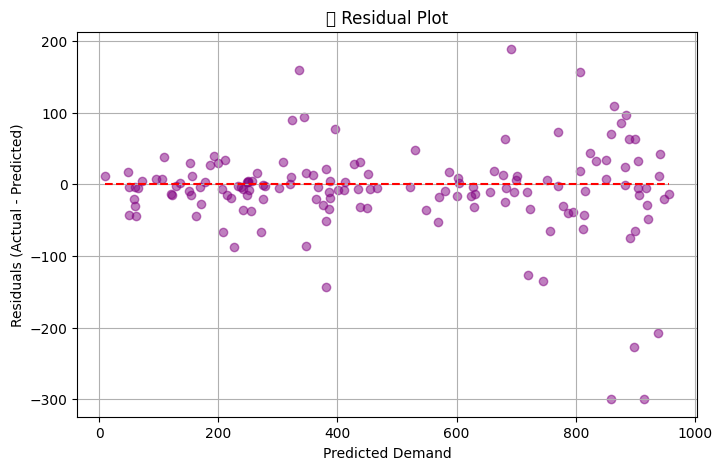

In [7]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color="purple")
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='dashed')
plt.xlabel("Predicted Demand")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("🔎 Residual Plot")
plt.grid(True)
plt.show()


/Users/amruthabhat/.pyenv/versions/3.12.3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


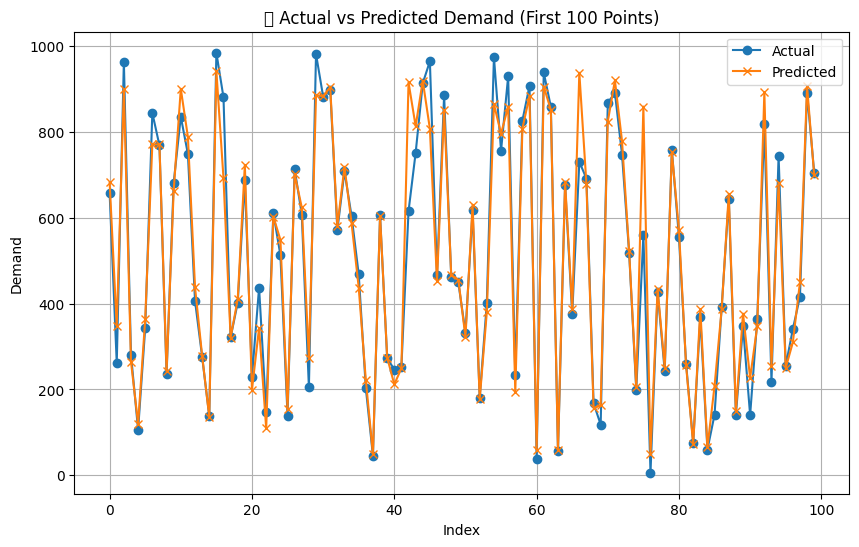

In [8]:
#Forecast vs actual over the time
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="Actual", marker='o')
plt.plot(y_pred[:100], label="Predicted", marker='x')
plt.title("🕒 Actual vs Predicted Demand (First 100 Points)")
plt.xlabel("Index")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()


/Users/amruthabhat/.pyenv/versions/3.12.3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


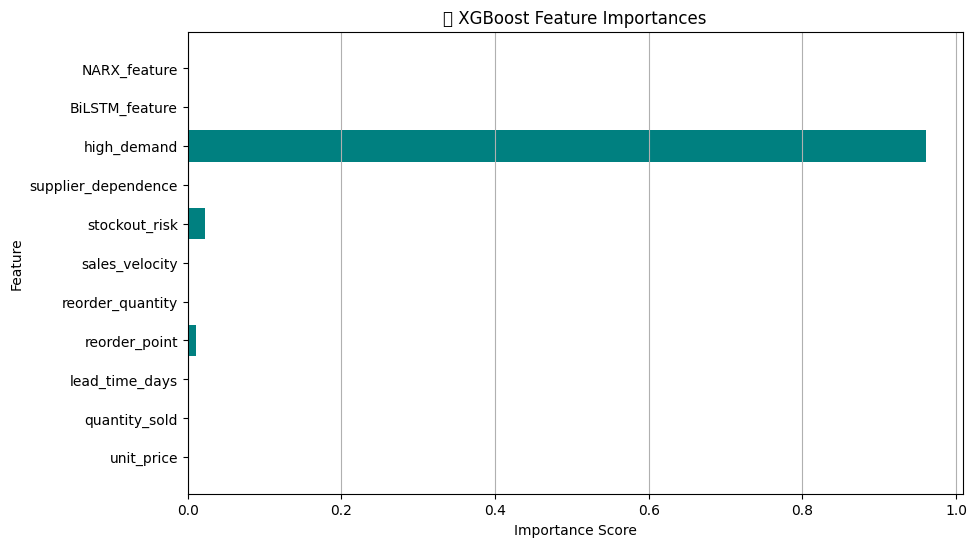

In [9]:
#feature importance from XGBoost 
importances = xgb_reg.feature_importances_
feature_names = list(X_test.columns) + ["BiLSTM_feature", "NARX_feature"]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='teal')
plt.title("💡 XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.show()
